In [21]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt

1) Reproduce the right part of Fig. 9.15 (leading to the decision in the third paragraph of Section 12.1.2 - use that paragraph to see whether your plots make sense)


In [22]:
data = pd.read_csv('BattingAverage.csv')
n_categories = len(data.PriPosNumber.unique())
n_players = len(data)
positions = data.PriPosNumber.to_numpy() -1 # -1 since PriPosNumber starts fro 1 but we want inexing from 0

In [23]:
def name_rownum(name):
    row_number = data[ (data.Player == name) ].index 
    return row_number

In [24]:
with pm.Model() as model:
    # the top-level prior (Hyper-parameters)
# In machine learning, a hyperparameter is a parameter whose value is set before the learning process begins.
# By contrast, the values of other parameters are derived via training.
    omega = pm.Beta ("omega", 1,1)
    kappa = pm.Deterministic(
        "kappa", 
        pm.Gamma ("kappa_minus_2", 0.01, 0.01) + 2
    )
    
    # paramaters for primary field positions (There are nine standard positions in baseball)
    omega_c = pm.Beta (
        "omega_c",      # TODO Why using f"" here but not for thete?
        omega * (kappa-2) +1, 
        (1-omega)*(kappa-2) +1, 
        shape=n_categories
    )
    
    kappa_c = pm.Deterministic (
        "kappa_c",
        pm.Gamma ("kappa_c_minus_2", 0.01, 0.01, shape=n_categories) + 2
    )
    
    # parameters for individual player 
    theta = pm.Beta('theta',
                     omega_c[positions]*(kappa_c[positions]-2)+1,
                    (1-omega_c[positions])*(kappa_c[positions]-2)+1,
                     shape = n_players)
    
    # We are using the same "speed-up" trick as Kruschke is doing, 
    # modeling experiences of each player as a Binomial distribution.
    # Note that above we have produced the theta vector in the same 
    # order as the players in the file, so the observed data in the 
    # binomial distribution will be applied correctly, per each of the 
    # variables in the vector.  It seems that because theta is a vector, 
    # the entire y variable is automatically vectorized.
    
    # Likelihood function
    y = pm.Binomial (
        'y', 
        n = data.AtBats.values, 
        p=theta, 
        observed=data.Hits,
        shape=n_players)
    
    Shi_minus_Ich = pm.Deterministic (
            "Shi_minus_Ich", 
            theta[[name_rownum('ShinSoo Choo')]] - theta[[name_rownum('Ichiro Suzuki')]]
        )

In [5]:
print(type(data.AtBats.values))
print(type(data.AtBats))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [25]:
with model:
    trace = pm.sample (5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus_2, omega_c, kappa_minus_2, omega]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [05:11<00:00, 70.65draws/s] 
The number of effective samples is smaller than 10% for some parameters.


/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chain

Text(0.5, 1.0, 'Kyle Blanks ( 1st Base ) − Bruce Chen ( Pitcher)')

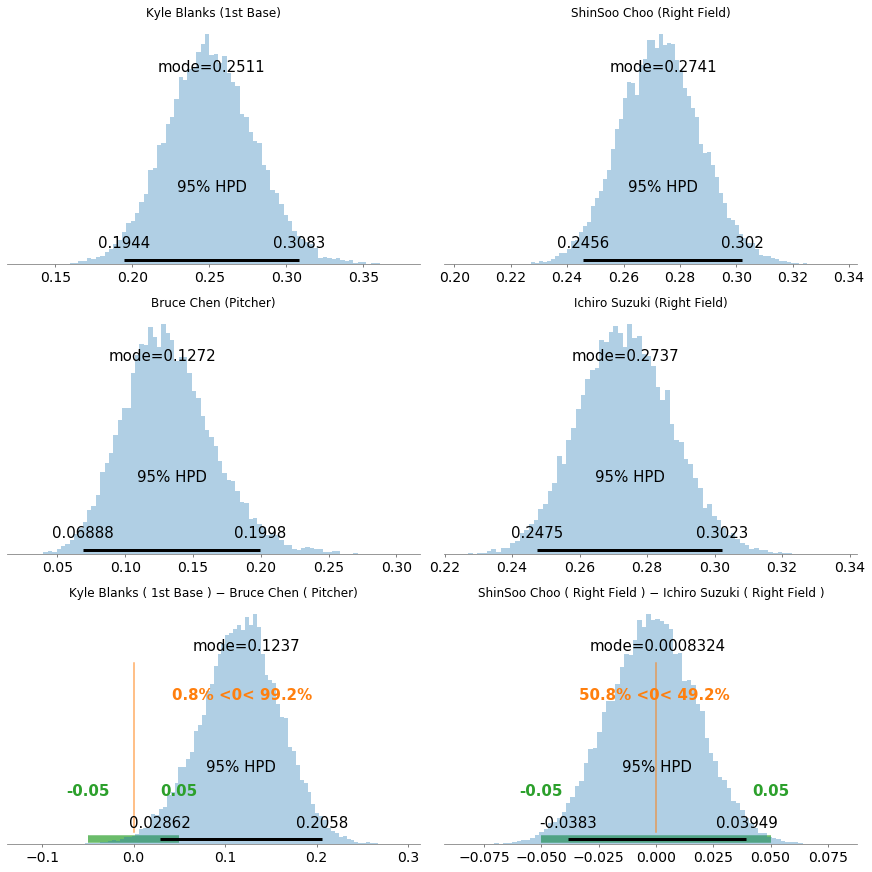

In [26]:
# fig, ax = plt.subplots(2,4, figsize=(15,5))

# Define gridspec
from matplotlib import gridspec
fig3 = plt.figure(constrained_layout=True, figsize=(12,12))
gs = fig3.add_gridspec(3, 6)
f3_ax1 = fig3.add_subplot(gs[0, :3])
f3_ax2 = fig3.add_subplot(gs[0, 3:])
f3_ax3 = fig3.add_subplot(gs[1, :3])
f3_ax4 = fig3.add_subplot(gs[1, 3:])
f3_ax5 = fig3.add_subplot(gs[2, :3])
f3_ax6 = fig3.add_subplot(gs[2, 3:])

# f3_ax5 = fig3.add_subplot(gs[-1, -2])


pm.plot_posterior(
    trace['theta'][:, name_rownum('ShinSoo Choo')], ax=f3_ax2, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax2.set_title("ShinSoo Choo (Right Field)")

pm.plot_posterior(
    trace['theta'][:, name_rownum('Ichiro Suzuki')], ax=f3_ax4, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax4.set_title("Ichiro Suzuki (Right Field)")

# How can I get mode with a specific precision?
# use round_to 
pm.plot_posterior(
        trace['Shi_minus_Ich'], ax=f3_ax6, point_estimate='mode', round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.05,+0.05)
    )
f3_ax6.set_title("ShinSoo Choo ( Right Field ) − Ichiro Suzuki ( Right Field )")




pm.plot_posterior(
    trace['theta'][:, name_rownum('Kyle Blanks')], ax=f3_ax1, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax1.set_title("Kyle Blanks (1st Base)")

pm.plot_posterior(
    trace['theta'][:, name_rownum('Bruce Chen')], ax=f3_ax3, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax3.set_title("Bruce Chen (Pitcher)")

# Kyle Blanks - Bruce Chen
pm.plot_posterior( trace['theta'][:, name_rownum('Kyle Blanks')] - trace['theta'][:, name_rownum('Bruce Chen')],
         ax=f3_ax5, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.05,+0.05)
    )
f3_ax5.set_title("Kyle Blanks ( 1st Base ) − Bruce Chen ( Pitcher)")


In [38]:
print(trace['theta'][name_rownum('ShinSoo Choo')].shape)
print(trace['theta'].shape)
print(trace['theta'][:, name_rownum('ShinSoo Choo')].shape)
# 20000 => trace = pm.sample (5000, cores=4) sampling 4 chains
print(trace['omega_c'][:, 1].shape)
trace['omega_c'][:, 0]

(1, 948)
(20000, 948)
(20000, 1)
(20000,)


array([0.11917492, 0.12313956, 0.12973606, ..., 0.11668892, 0.12075659,
       0.12401179])

In [9]:
# TODO It is likelihood
# trace['y']

Text(0, 0.5, 'Ichiro Suzuki')

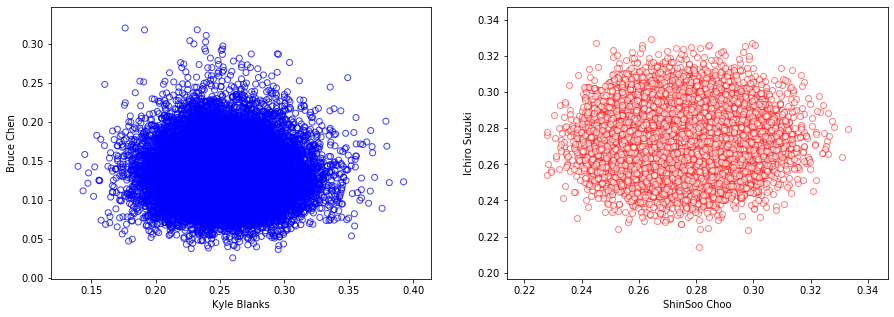

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(trace['theta'][:, name_rownum('Kyle Blanks')], trace['theta'][:, name_rownum('Bruce Chen')], 
            alpha=0.75, color='blue', facecolor='none')
ax[0].set_xlabel("Kyle Blanks")
ax[0].set_ylabel("Bruce Chen")
# ax[0].set_xlim(0.16,0.35)
# ax[0].set_ylim(0.02,0.25)



ax[1].scatter(trace['theta'][:, name_rownum('Ichiro Suzuki')], trace['theta'][:, name_rownum('ShinSoo Choo')],
            alpha=0.50, color='red', facecolor='white')
ax[1].set_xlabel("ShinSoo Choo")
ax[1].set_ylabel("Ichiro Suzuki")
# ax[0].set_xlim(0.23,0.33)
# ax[0].set_ylim(0.23,0.33)

2. Attempt to regenerate Figures 12.1 from the book following these steps: 
* Generate a random sample of $\theta_1$ using a normal distribution with mode 0.58 and $\theta_2 = Normal(\theta_1, 0.08)$ 
* Explain why the above parameters have been selected for the generator
* Plot the four figures from the sample

   One way to do the above fairly fast is to build a pymc3 model without observation data and sample from this one (as if we sampled from the prior).

In [18]:
with pm.Model() as model_left:
    mode = 0.58
    θ1 = pm.Normal('θ1', mu=mode, sd=0.08)
    
    θ2 = pm.Normal('θ2', θ1, 0.08)  
    
    θ1_minus_θ2 = pm.Deterministic (
            "θ1_minus_θ2", 
            θ1 - θ2
        )   

In [19]:
with model_left:
    trace_left = pm.sample (1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1637.80draws/s]


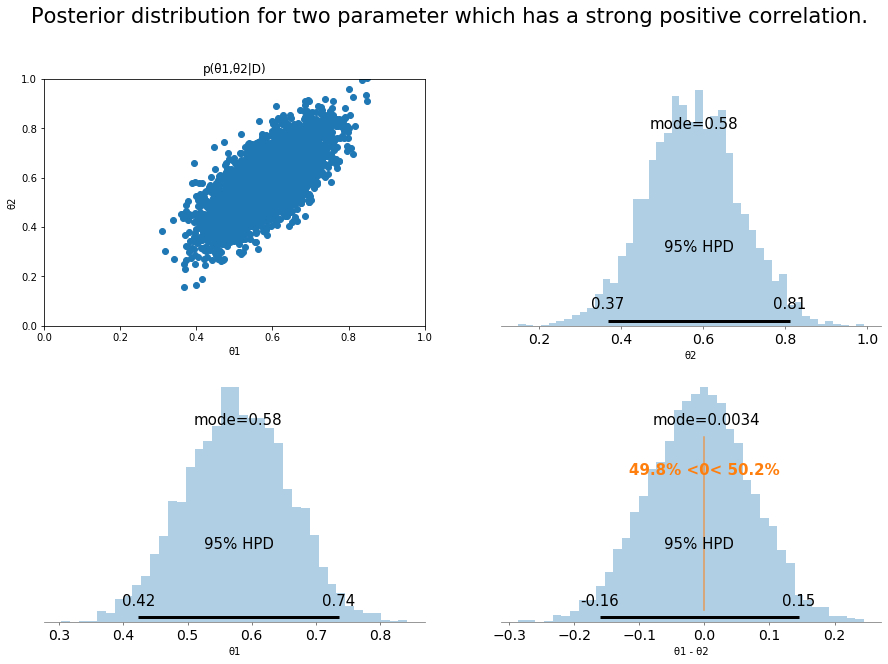

In [20]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Posterior distribution for two parameter which has a strong positive correlation.', fontsize='21')

ax[0,0].scatter(trace_left['θ1'], trace_left['θ2'])
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)

pm.plot_posterior(trace_left['θ2'], ax=ax[0,1], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_left['θ1'], ax=ax[1,0], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_left['θ1_minus_θ2'], ax=ax[1,1], kind='hist', point_estimate='mode', 
                  credible_interval=0.95, ref_val=0.0)

ax[0,0].set_title("p(θ1,θ2|D)")
ax[0,1].set_title("")
ax[1,0].set_title("")
ax[1,1].set_title("")

ax[0,0].set_xlabel("θ1")
ax[0,0].set_ylabel("θ2")

ax[0,1].set_xlabel("θ2")
ax[1,0].set_xlabel("θ1")
ax[1,1].set_xlabel("θ1 - θ2");

# covariance vs correlation
In simple words, both the terms measure the relationship and the dependency between two variables. “Covariance” indicates the direction of the linear relationship between variables. “Correlation” on the other hand measures both the strength and direction of the linear relationship between two variables.

In [152]:
# correlation
corrcoef = np.corrcoef(trace_left['θ1'], trace_left['θ2'])

# Pearson’s Correlation
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(trace_left['θ1'], trace_left['θ2'])
print(corrcoef, corr, sep='\n')

[[1.         0.06193855]
 [0.06193855 1.        ]]
0.06193854574432842


# covariance
https://www.investopedia.com/terms/c/correlationcoefficient.asp

A value of exactly 1.0 means there is a perfect positive relationship between the two variables. For a positive increase in one variable, there is also a positive increase in the second variable. A value of -1.0 means there is a perfect negative relationship between the two variables. This shows that the variables move in opposite directions - for a positive increase in one variable, there is a decrease in the second variable. If the correlation between two variables is 0, there is no linear relationship between them.

In [141]:
# https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/
# The sign of the covariance can be interpreted as whether the two variables change in the 
# same direction (positive) or change in different directions (negative). The magnitude of the covariance 
# is not easily interpreted. A covariance value of zero indicates that both variables are completely independent.
covariance = np.cov(trace_left['θ1'], trace_left['θ2'])
# The diagonal of the matrix contains the covariance between each variable and itself. The other values 
# in the matrix represent the covariance between the two variables; in this case, the remaining two values 
# are the same given that we are calculating the covariance for only two variables.
print(covariance)
# The diagonal elements, Cii are the variances in the variables xi
print(np.var(trace_left['θ1']))
print(np.var(trace_left['θ2']))

# The covariance between the two variables is 0.01038589. We can see that it is positive, 
# suggesting the variables change in the same direction as we expect.

[[0.00710554 0.01038589]
 [0.01038589 3.95701678]]
0.007103765626520667
3.9560275237422693


3. Repeat the exercise with a different generator of the sample, to reproduce the second part of the figure:
* Generate a random sample of $\theta_1$ with mode 0.58 as above and $\theta_2 = Normal(1 - \theta_1, 0.08)$ 
* ...

In [265]:
with pm.Model() as model_right:
    mode = 0.58
    θ1 = pm.Normal ("θ1", mu=mode, sd=0.08)
    
    θ2 = pm.Normal('θ2', 1-θ1, 0.08)  
    
    θ1_minus_θ2 = pm.Deterministic (
            "θ1_minus_θ2", 
            θ1 - θ2
        )   

In [266]:
with model_right:
    trace_right = pm.sample (1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1420.51draws/s]


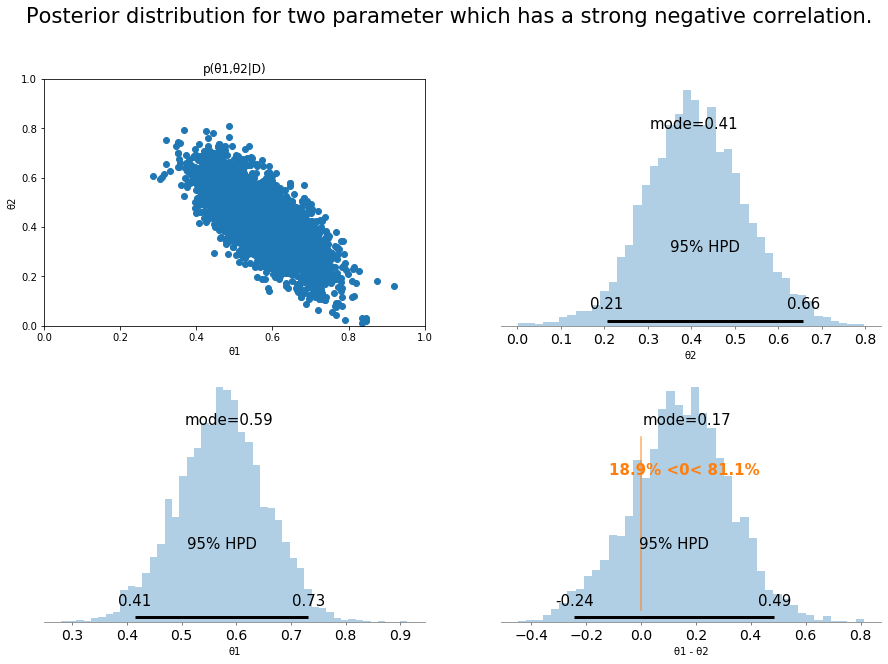

In [267]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Posterior distribution for two parameter which has a strong negative correlation.', fontsize='21')


ax[0,0].scatter(trace_right['θ1'], trace_right['θ2'])
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)

pm.plot_posterior(trace_right['θ2'], ax=ax[0,1], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_right['θ1'], ax=ax[1,0], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_right['θ1_minus_θ2'], ax=ax[1,1], kind='hist', point_estimate='mode', 
                  credible_interval=0.95, ref_val=0.0)

ax[0,0].set_title("p(θ1,θ2|D)")
ax[0,1].set_title("")
ax[1,0].set_title("")
ax[1,1].set_title("")

ax[0,0].set_xlabel("θ1")
ax[0,0].set_ylabel("θ2")

ax[0,1].set_xlabel("θ2")
ax[1,0].set_xlabel("θ1")
ax[1,1].set_xlabel("θ1 - θ2");

In [271]:
covariance = np.cov(trace_right['θ1'], trace_right['θ2'])
correlation = np.corrcoef(trace_right['θ1'], trace_right['θ2'])
print(covariance, correlation, sep='\n')

[[ 0.00667011 -0.00672673]
 [-0.00672673  0.01321094]]
[[ 1.         -0.71658956]
 [-0.71658956  1.        ]]


4. Repeat the exercises 2-3 but now save your sample in a file (or a variable) and use it as data for another model with a weak prior. Use the inference to estimate the posteriors and replot the same plots.  It is interesting to compare the HDI endpoints between 1/2 and 3.

   Note that posterior_plot (search in: https://docs.pymc.io/api/plots.html) takes the 'rope' as a parameter, so we can even add some simple (fake) ROPEs to the above plots. I recommend that you try that.

In [316]:
# Save sample
# the default directory where the traces are saved is hidden.
# pm.backends.ndarray.save_trace(trace_right, 'saved_traces')
pm.save_trace(trace_right, "saved_trace_right") #, overwrite=True

'saved_trace_right'

In [325]:
# Load sample
# pymc3.backends.ndarray.load_trace
MR = pm.load_trace('saved_trace_right', model=model_right)
len(MR.get_values('θ1', chains=[0,3]))

2000

In [353]:
max(MR.get_values('θ1', chains=[0]))

0.819610764734565

In [356]:
Data = MR.get_values('θ1')
# Data = [0.5,0.6,0.6,0.8,0.4]
with pm.Model() as model_weak_prior:
    theta = pm.Beta(name="theta1", alpha=1, beta=1)
    y = pm.Bernoulli(name="obs", p=theta, observed=Data) # likelihood

In [361]:
with model_weak_prior:
    trace_weak_prior = pm.sample (1000, cores=4) # defualt tune is 500 for each chain

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 836.06draws/s] 
The number of effective samples is smaller than 10% for some parameters.


In [362]:
ppc = pm.sample_posterior_predictive(trace=trace_weak_prior, samples=500, model=model_weak_prior)

/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 500/500 [00:00<00:00, 1292.91it/s]


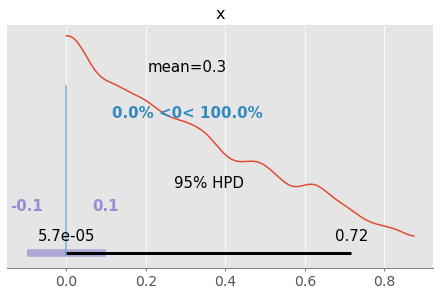

In [369]:
pm.plot_posterior(trace_weak_prior[theta], credible_interval=0.95, ref_val=0.0,rope=(-0.1, 0.1));

In [344]:
with pm.Model() as model_test:
    theta_test = pm.Beta(name="theta11", alpha=1, beta=1)
    
    trace_test = pm.sample (1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta11]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2062.62draws/s]


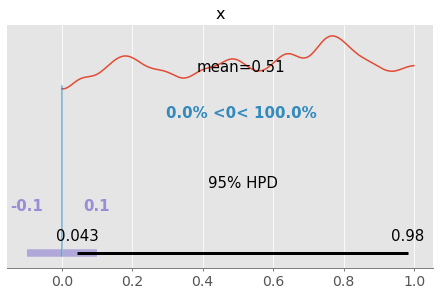

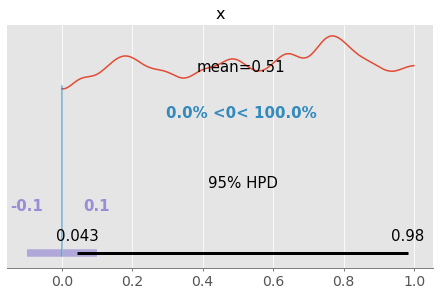

In [348]:
pm.plot_posterior(trace_test['theta11'], credible_interval=0.95, ref_val=0.0,rope=(-0.1, 0.1));
pm.plot_posterior(trace_test[theta_test], credible_interval=0.95, ref_val=0.0,rope=(-0.1, 0.1));